In [1]:
%matplotlib inline
import random
import numpy as np
import pandas as pd
import seaborn as sns
from pprint import pprint
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier

In [2]:
training_data = "results/test_training_data.txt"

class_dict = {'mangrove': 1, 'nonmangrove': 0}

field = 'PXLVAL'

In [3]:
# load the data
model_input = np.loadtxt(training_data)

# load the column_names
with open(training_data, 'r') as file:
    header = file.readline()

column_names = header.split()[1:]

# Extract relevant indices from training data
model_col_indices = [
    column_names.index(var_name) for var_name in column_names[1:]
]

In [4]:
dfs = {}

# Insert data into a Pandas DataFrame, then split into features and labels
model_input_df = pd.DataFrame(model_input, columns=column_names)
X = model_input_df.drop(field, axis=1)
y = model_input_df[[field]]

# Fit the standard scaler to all features
scaler = StandardScaler(with_mean=False)
scaler.fit(X);

for key, value in class_dict.items():
    print(key, value)
    # extract values for class from training data
    arr = model_input[model_input[:,0]==value]
    # create a pandas df for ease of use later
    df = pd.DataFrame(arr).rename(columns={i:column_names[i] for i in range(0,len(column_names))}).drop(field, axis=1)
    # Scale the dataframe
    scaled_df = scaler.transform(df)
    scaled_df = pd.DataFrame(scaled_df, columns=df.columns)

    dfs.update({key:scaled_df})

mangrove 1
nonmangrove 0


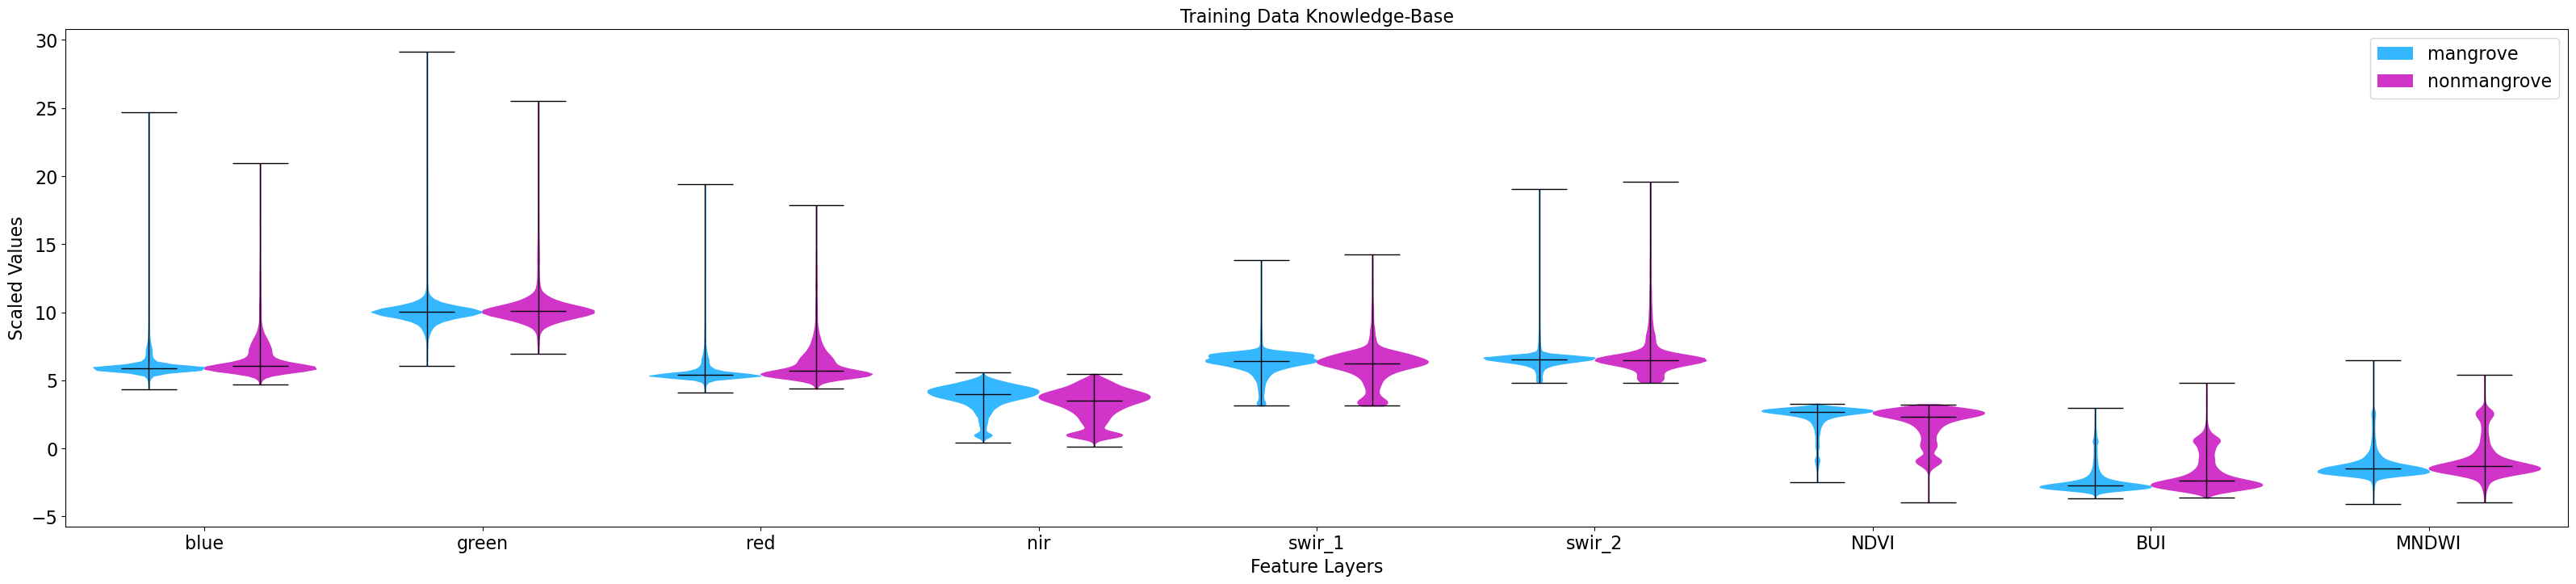

In [5]:
# Generate a random list of colors same length as num of classes
get_colors = lambda n: list(
    map(lambda i: "#" + "%06x" % random.randint(0, 0xFFFFFF), range(n)))
colors = get_colors(len(dfs))

# Generate list of offsets & widths for plotting
start = -0.2
end = 0.2
offsets = list(np.linspace(start, end, len(dfs)))
if len(dfs) == 2:
    width = 0.4
else:
    width = np.abs(offsets[0] - offsets[1])

# Create figure and axes
fig, ax = plt.subplots(figsize=(40, 8))

for key, color, offset in zip(dfs, colors, offsets):
    # Create violin plots
    pp = ax.violinplot(dfs[key].values,
                       showmedians=True,
                       positions=np.arange(dfs[key].values.shape[1]) + offset,
                       widths=width)
    # Change the colour of the plots
    for pc in pp['bodies']:
        pc.set_facecolor(color)
        pc.set_edgecolor(color)
        pc.set_alpha(1)

    # Change the line style in the plots
    for partname in ('cbars', 'cmins', 'cmaxes', 'cmedians'):
        vp = pp[partname]
        vp.set_edgecolor('black')
        vp.set_linewidth(1)

# Tidy the plot, add a title and legend
ax.set_xticks(np.arange(len(column_names[1:])))
ax.set_xticklabels(column_names[1:])
ax.set_xlim(-0.5, len(column_names[1:]) - .5)
ax.set_ylabel("Scaled Values", fontsize=16)
ax.set_xlabel("Feature Layers", fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=16)
ax.set_title("Training Data Knowledge-Base", fontsize=16)
ax.legend([Patch(facecolor=c) for c in colors], [key for key in dfs],
          loc='upper right',
          fontsize=16);

In [6]:
model=RandomForestClassifier(random_state=42)
model.fit(X, y.values.ravel());

/home/adithya/anaconda3/envs/odc_env/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


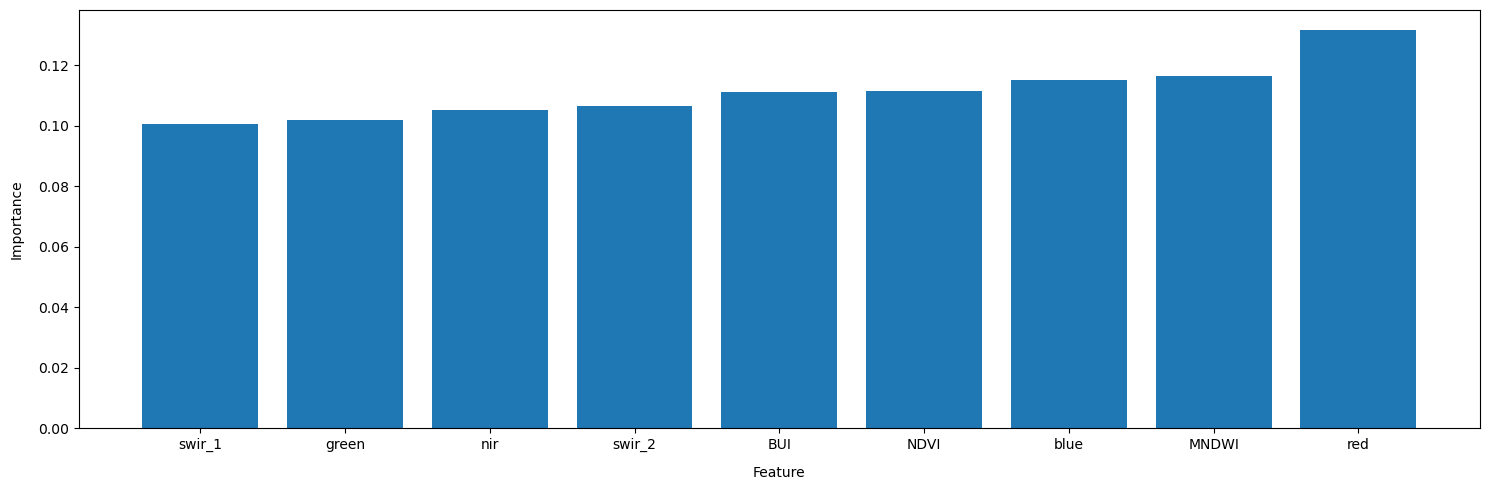

In [7]:
order = np.argsort(model.feature_importances_)

plt.figure(figsize=(15, 5))
plt.bar(x=np.array(column_names[1:])[order],
        height=model.feature_importances_[order])
plt.gca().set_ylabel('Importance', labelpad=10)
plt.gca().set_xlabel('Feature', labelpad=10)
plt.tight_layout()

In [8]:
# Compute the mean and variance for each feature
X_scaled = scaler.transform(X)

In [9]:
# Two components
pca2 = PCA(n_components=2)
pca2_fit = pca2.fit_transform(X_scaled)
# Three PCA components
pca3 = PCA(n_components=3)
pca3_fit = pca3.fit_transform(X_scaled)

# Add back to df
pca2_df = pd.DataFrame(data=pca2_fit, columns=['PC1', 'PC2'])
pca3_df = pd.DataFrame(data=pca3_fit, columns=['PC1', 'PC2', 'PC3'])

# Concat with classes
result2 = pd.concat(
    [pca2_df, pd.DataFrame({'class': model_input[:, 0]})], axis=1)
result3 = pd.concat(
    [pca3_df, pd.DataFrame({'class': model_input[:, 0]})], axis=1)

In [10]:
a2, b2 = pca2.explained_variance_ratio_
a3, b3, c3 = pca3.explained_variance_ratio_
print("Variance explained by two principal components = " +
      str(round((a2 + b2) * 100, 2)) + " %")
print("Variance explained by three principal components = " +
      str(round((a3 + b3 + c3) * 100, 2)) + " %")

Variance explained by two principal components = 88.22 %
Variance explained by three principal components = 97.17 %


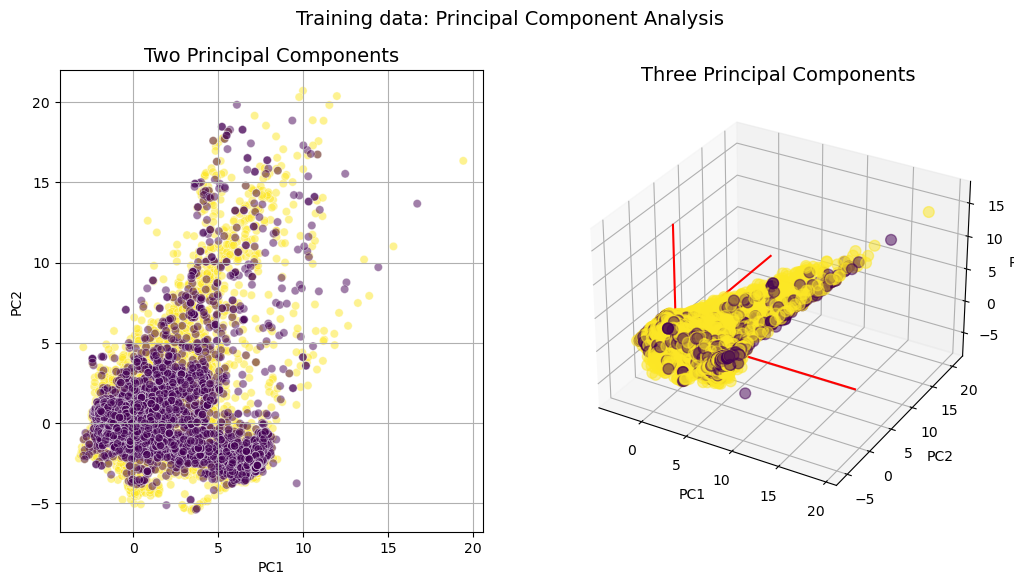

In [11]:
fig = plt.figure(figsize=(12, 6))
fig.suptitle('Training data: Principal Component Analysis', fontsize=14)

# First subplot
ax = fig.add_subplot(1, 2, 1)
scatter1 = sns.scatterplot(x="PC1",
                           y="PC2",
                           data=result2,
                           hue='class',
                           hue_norm=tuple(np.unique(result2['class'])),
                           palette='viridis',
                           legend=False,
                           alpha=0.5,
                           ax=ax)

ax.set_title('Two Principal Components', fontsize=14)
ax.grid(True)

# Second subplot
ax = fig.add_subplot(1, 2, 2, projection='3d')
scatter2 = ax.scatter(result3['PC1'],
                      result3['PC2'],
                      result3['PC3'],
                      c=result3['class'],
                      s=60,
                      alpha=0.5)

# Make simple, bare axis lines through space:
xAxisLine = ((min(result3['PC1']), max(result3['PC1'])), (0, 0), (0, 0))
ax.plot(xAxisLine[0], xAxisLine[1], xAxisLine[2], 'r')
yAxisLine = ((0, 0), (min(result3['PC2']), max(result3['PC2'])), (0, 0))
ax.plot(yAxisLine[0], yAxisLine[1], yAxisLine[2], 'r')
zAxisLine = ((0, 0), (0, 0), (min(result3['PC3']), max(result3['PC3'])))
ax.plot(zAxisLine[0], zAxisLine[1], zAxisLine[2], 'r')

ax.set_title('Three Principal Components', fontsize=14)
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3");